In [0]:
import pandas as pd
from typing import Any, Dict, Optional

class HistGBTFeatureImportance:
    def __init__(self, model: Any):
        """
        Parameters
        ----------
        model : HistGradientBoostingClassifier or HistGradientBoostingRegressor
            A trained scikit-learn histogram-based GBM model.
        """
        self.model = model
        self._validate_model()
        self.feature_idx_to_name = self._get_feature_idx_to_name()
        
    def _validate_model(self):
        if not hasattr(self.model, "_predictors") or not hasattr(self.model, "feature_names_in_"):
            raise ValueError("Model must be a fitted HistGradientBoostingClassifier/Regressor with feature_names_in_.")
        if not getattr(self.model, "_predictors"):
            raise ValueError("No predictors (trees) found in the provided model.")

    def _get_feature_idx_to_name(self) -> Dict[int, str]:
        return dict(enumerate(self.model.feature_names_in_))

    def _extract_nodes_dataframe(self) -> pd.DataFrame:
        dataframes = []
        for i, tree in enumerate(self.model._predictors):
            if len(tree) == 1:
                raise ValueError(f"Tree at index {i} does not have exactly one element.")
            tree_source = tree[0]
            if not hasattr(tree_source, "nodes"):
                raise ValueError(f"Tree source at index {i} lacks 'nodes' attribute.")
            df = pd.DataFrame(tree_source.nodes)
            dataframes.append(df)
        if not dataframes:
            raise ValueError("No trees found in the model.")
        return pd.concat(dataframes, ignore_index=True)

    def feature_calculate_importance(self, normalize: bool = False) -> pd.DataFrame:
        """
        Calculate feature importances based on gain.

        Parameters
        ----------
        normalize : bool
            Whether to normalize the importance scores so they sum to 1.

        Returns
        -------
        pd.DataFrame
            DataFrame with columns 'feature_name' and 'importance', sorted descendingly.
        """
        combined_df = self._extract_nodes_dataframe()
        branch_nodes = combined_df[combined_df["is_leaf"] == 0].copy()

        if branch_nodes.empty:
            raise ValueError("No branch (split) nodes found in the trees.")

        branch_nodes["feature_name"] = branch_nodes["feature_idx"].map(self.feature_idx_to_name)
        feature_importances = branch_nodes.groupby("feature_name")["gain"].sum()

        if normalize:
            feature_importances = feature_importances / feature_importances.sum()

        out = feature_importances.sort_values(ascending=False).reset_index()
        out.rename(columns={"gain": "importance"}, inplace=True)

        return out

    def to_dict(self, normalize: bool = False) -> Dict[str, float]:
        """
        Returns importances as a dictionary.

        Parameters
        ----------
        normalize : bool
            Whether to normalize the importance scores.

        Returns
        -------
        dict
            {feature_name: importance, ...}
        """
        df = self.feature_calculate_importance(normalize=normalize)
        return dict(zip(df["feature_name"], df["importance"]))

    def plot(self, normalize: bool = False, model_type: str="classification", top_k: Optional[int] = None):
        """
        Optional: Visualize importances using matplotlib.

        Parameters
        ----------
        normalize : bool
            Whether to normalize the importance scores.
        top_k : int or None
            If set, plot only the top_k features.
        """
        import matplotlib.pyplot as plt

        model_type_str = "regression" if model_type == "GradientBoostingRegressor" else "HistGradientBoostingClassifier"

        df = self.feature_calculate_importance(normalize=normalize)
        if top_k is not None:
            df = df.head(top_k)
        plt.figure(figsize=(8, 5))
        plt.barh(df["feature_name"], df["importance"])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.title(f"{model_type_str} feature importances")
        plt.gca().invert_yaxis()
        plt.show()


                    feature_name  importance
0                        proline  518.185206
1                     flavanoids  122.882900
2                        alcohol   32.791158
3              alcalinity_of_ash    8.785622
4                  total_phenols    8.022371
5                     malic_acid    3.405272
6                proanthocyanins    0.632541
7           nonflavanoid_phenols    0.586752
8   od280/od315_of_diluted_wines    0.324101
9                            ash    0.321257
10               color_intensity    0.261437
11                     magnesium    0.024280
12                           hue    0.000765
{'proline': 0.7442797978163488, 'flavanoids': 0.1764991726297917, 'alcohol': 0.0470985972012675, 'alcalinity_of_ash': 0.012618964716886064, 'total_phenols': 0.011522692022363371, 'malic_acid': 0.004891060561220922, 'proanthocyanins': 0.0009085319857206795, 'nonflavanoid_phenols': 0.0008427632876244951, 'od280/od315_of_diluted_wines': 0.0004655122475924958, 'ash': 0.00

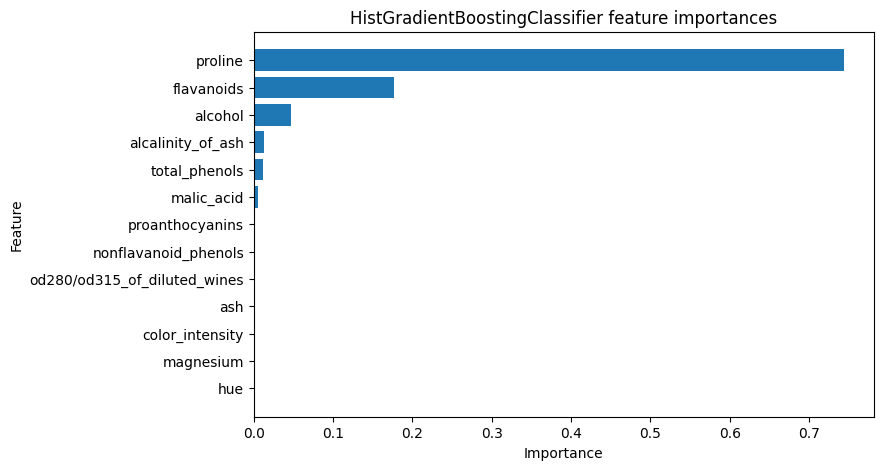

In [0]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.datasets import load_wine

X, y = load_wine(return_X_y=True, as_frame=True)

histgbt = HistGradientBoostingClassifier(random_state=42)
model = histgbt.fit(X, y)

fi = HistGBTFeatureImportance(model)
df = fi.feature_calculate_importance()
print(df)

# Dictionary output
print(fi.to_dict(normalize=True))

# Optional plot
fi.plot(normalize=True)